<a href='https://www.kaggle.com/fatmakursun/pyspark-ml-tutorial-for-beginners'>Kaggle 튜토리얼 출처</a>

In [1]:
import os
import pandas as pd
import numpy as np

# pyspark for objecy, sql
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

# pyspark for ML
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Setting for visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid',
       rc={'figure.figsize': (18, 4)})
rcParams['figure.figsize'] = 18, 4

In [4]:
# 노트북 재실행을 대비하기 위해 랜덤 시드 설정해놓기
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

### Creating Spark Session

In [5]:
spark = SparkSession.builder.master('local[2]')\
        .appName('Linear-Regression-California-Housing')\
        .getOrCreate()

In [6]:
spark

In [7]:
# SparkContext 객체와 SQLContext 객체 생성
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=PySparkShell>

In [8]:
# SQLContext는 sparkContext를 집어넣어주자
sqlContext = SQLContext(spark.sparkContext)
sqlContext

### Load file and convert it into DataFrame

In [9]:
data_path = '/Users/younghun/Desktop/gitrepo/data/cal_housing.data'

In [10]:
# data의 칼럼명을 스키마로 정의해주기
schema_string = 'long lat medage totrooms totbdrms pop houshlds medinc medhv'

fields = [StructField(field, FloatType(), True)for field in schema_string.split()]
schema = StructType(fields)
schema

StructType(List(StructField(long,FloatType,true),StructField(lat,FloatType,true),StructField(medage,FloatType,true),StructField(totrooms,FloatType,true),StructField(totbdrms,FloatType,true),StructField(pop,FloatType,true),StructField(houshlds,FloatType,true),StructField(medinc,FloatType,true),StructField(medhv,FloatType,true)))

In [11]:
# 데이터파일 로드
# cache 메소드를 이용해서 메모리에 keep해놓기
housing_df = spark.read.csv(path=data_path, schema=schema).cache()

# 상위 5개 행 미리 보기 -> 하나의 Row가 namedTuple 형태로 되어 있음..!
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [12]:
# 로드한 데이터프레임 형태 미리보기
housing_df.show(6)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|269700.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 6 rows



In [13]:
# 칼럼들 보기
print(housing_df.columns,'\n',type(housing_df.columns))

['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv'] 
 <class 'list'>


In [14]:
# 데이터프레임의 schema 보기
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



### Data Exploration

In [15]:
# 특정 칼럼값들만 추출하기 -> select메소드 이용
housing_df.select('pop', 'medinc').show()

+------+------+
|   pop|medinc|
+------+------+
| 322.0|8.3252|
|2401.0|8.3014|
| 496.0|7.2574|
| 558.0|5.6431|
| 565.0|3.8462|
| 413.0|4.0368|
|1094.0|3.6591|
|1157.0|  3.12|
|1206.0|2.0804|
|1551.0|3.6912|
| 910.0|3.2031|
|1504.0|3.2705|
|1098.0| 3.075|
| 345.0|2.6736|
|1212.0|1.9167|
| 697.0| 2.125|
| 793.0| 2.775|
| 648.0|2.1202|
| 990.0|1.9911|
| 690.0|2.6033|
+------+------+
only showing top 20 rows



In [16]:
# 그룹핑해서 집계해보기
result_df = housing_df.groupBy('medage').count()
result_df.show(5)

+------+-----+
|medage|count|
+------+-----+
|  18.0|  570|
|  47.0|  198|
|   9.0|  205|
|  39.0|  369|
|   5.0|  244|
+------+-----+
only showing top 5 rows



In [17]:
# 값 정렬 기준 설정해주고 내림차순으로 정렬
result_df.sort('medage', ascending=False).show(5)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
+------+-----+
only showing top 5 rows



<AxesSubplot:xlabel='medage'>

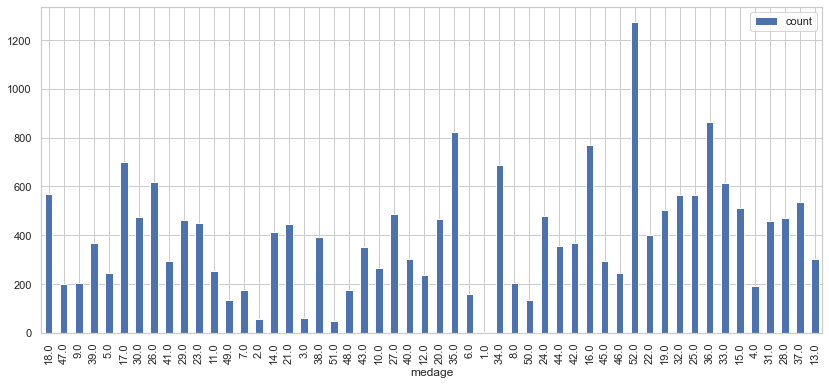

In [18]:
# Bar graph 그리기
# toPandas() 이용
result_df.toPandas().plot.bar(x='medage', figsize=(14, 6))

- Summary Statistics
    * ``describe()``메소드를 이용해 수치형 컬럼에 대한 통계량값들 데이터 프레임으로 반환 가능


In [19]:
housing_df.describe().show(1)

+-------+-----+-----+------+--------+--------+-----+--------+------+-----+
|summary| long|  lat|medage|totrooms|totbdrms|  pop|houshlds|medinc|medhv|
+-------+-----+-----+------+--------+--------+-----+--------+------+-----+
|  count|20640|20640| 20640|   20640|   20640|20640|   20640| 20640|20640|
+-------+-----+-----+------+--------+--------+-----+--------+------+-----+
only showing top 1 row



- F: sql에서 사용할수 있는 여러가지 함수 담겨있는 라이브러리
    * ``F.function('column')``

In [20]:
# 반환되는 통계량 값들을 소수점 제거하거나 하는 등 커스터마이징해서 출력
(housing_df.describe()).select('summary',
                              F.round('medage', 4).alias('medage'),
                              F.round('totrooms', 4).alias('totrooms'),
                              F.round('totbdrms', 4).alias('totbdrms'),
                              F.round('pop', 4).alias('pop'),
                              F.round('houshlds', 4).alias('houshlds'),
                              F.round('medinc', 4).alias('medinc'),
                              F.round('medhv', 4).alias('medhv')).show(10)

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



### Data Preprocessing

- ``withColumn('새로운col', col('변경할col)/10000)``

In [21]:
# 변수에 연산을 취한 후 재할당
housing_df = housing_df.withColumn('medhv', col('medhv')/100000)
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 5 rows



### Feature Engineering

- 이 때, ``F : sql.functions``
- ``dataframe.withColumn('New변수명', F.round(col('기존변수')/col('기존변수2'), 2)).withColumn('New변수명2', F.round(col('기존변수3')/col('기존변수4'), 2)).withColumn....``

In [22]:
# 파생변수 생성하기
housing_df = (housing_df.withColumn('rmsperhh',
                                   F.round(col('totrooms')/col('houshlds'), 2))\
                        .withColumn('popperhh',
                                   F.round(col('pop')/col('houshlds'), 2))\
                        .withColumn('bdrmsperrm',
                                   F.round(col('totbdrms')/col('totrooms'), 2)))
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



In [23]:
# 사용하지 않을 변수 제외하고 필요한 변수들만 select
housing_df = housing_df.select('medhv',
                              'totbdrms',
                              'pop',
                              'houshlds',
                              'medinc',
                              'rmsperhh',
                              'popperhh',
                              'bdrmsperrm')
housing_df.show(4)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 4 rows



### Feature Extraction

- 특정 피처들을 정규화시키기 위해서 피처들 값들을 feature vector로 바꾸어 주기 위해서 ``VectorAssembler``를 사용

In [24]:
featureCols = ['totbdrms', 'pop', 'houshlds', 'medinc',
              'rmsperhh', 'popperhh', 'bdrmsperrm']
# VectorAssembler로 feature vector로 변환
assembler = VectorAssembler(inputCols=featureCols, outputCol='features')
assembled_df = assembler.transform(housing_df)
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


- Standardization
    * ``StandardScaler(inputCol, outputCol)`` 후 ``fit``, ``transform``사용

In [25]:
# 위에서 만든 Feature vector인 'features' 넣기
standardScaler = StandardScaler(inputCol='features',
                               outputCol='features_scaled')
# fit, transform
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

# scaling된 피처들만 추출해보기
scaled_df.select('features', 'features_scaled').show(10,
                                                    truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

### Build ML using Spark ML

- split train, test data
    * ``randomSplit()`` 사용

In [26]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=rnd_seed)
print(type(train_data))
train_data.columns

<class 'pyspark.sql.dataframe.DataFrame'>


['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

#### Elastic Net regression 사용
- ``elasticNetParam``: ``L1의 alpha``와 동일. 그래서 이 값이 1이면 Lasso와 동일, 만약 0이면 Ridged와 동일
    
- ``regParam``: L1, L2을 얼마나 규제할지 계수값
- ``featuresCol``: 독립변수
- ``labelCol``: 종속변수
- ``predictionCol``: 예측값으로 생성할 변수

In [27]:
# Elastic Net 모델 정의
lr = LinearRegression(featuresCol='features_scaled',
                     labelCol='medhv',
                     predictionCol='predmedhv',
                     maxIter=10,
                     regParam=0.3,
                     elasticNetParam=0.8,
                     standardization=False)
# 모델 학습
linearModel = lr.fit(train_data)

### Evaluating Model

- 예측 시에는 ``model.transform(data)``사용!

In [28]:
# Elastic Net의 feature별 회귀계수 값들 살펴보기
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [32]:
print(featureCols, type(featureCols))

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm'] <class 'list'>


In [30]:
# Vertical Intercept(y절편) 살펴보기
linearModel.intercept

1.0013833516596085

In [33]:
# 피처별로 회귀계수값과 절편값 pandas의 데이터프레임으로 만들기
coeff_df = pd.DataFrame({'Feature': ['Intercept'] + featureCols,
                        'Co-efficients': np.insert(linearModel.coefficients,
                                                  0, linearModel.intercept)})
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


#### Generating Predictions

In [34]:
# transoform 사용하면 모델 정의할 때 설정한 "예측 값 변수"를 새로 만들어 생성한 데이터프레임 반환
predictions = linearModel.transform(test_data)
print(type(predictions))

<class 'pyspark.sql.dataframe.DataFrame'>


In [35]:
# predictions 데이터프레임에서 y값과 예측값만 추출해 비교
pred_labels = predictions.select('predmedhv', 'medhv')
pred_labels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|  1.14982901467337|0.14999|
|1.3037582901805782|  0.225|
| 1.752972574315186|  0.225|
|1.6094289295308724|  0.269|
|1.5956645319495768|  0.344|
|1.2917940087238426|  0.367|
|1.8668547795751218|  0.375|
| 1.369423339785637|  0.394|
|1.5305533439120043|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043998|  0.417|
| 1.229923204690587|  0.425|
|1.4841640700933143|  0.425|
|1.3510338217435218|   0.43|
|1.2619110212709588|  0.436|
|1.3350814464678744|   0.44|
|1.4832778453641755|   0.44|
|1.4337313361080328|  0.444|
|1.3691187093204966|  0.445|
|  1.47521855868216|  0.446|
+------------------+-------+
only showing top 20 rows



#### Get evaluation using metric

- ``LinearRegressionModel.summary`` 이용하기
    * ``rootMeanSquaredError``,``meanAbsoluteError``,``r2`` 등 반환 가능

In [37]:
print(f"RMSE:{linearModel.summary.rootMeanSquaredError}")
print(f"MAE: {linearModel.summary.meanAbsoluteError}")
print(f"R2 score: {linearModel.summary.r2}")

RMSE:0.8819852045268861
MAE: 0.6782895319917991
R2 score: 0.4180854895364573


#### RegressionEvaluator

- ``RegreesionEvaluator(predictionCol, labelCol, metricName)``
    * ``predictionCol``: 예측값 변수
    * ``labelCol``: 실제 y값 변수
    * ``metricName``: metric 이름
    
- ``evaluate(예측값)`` 넣어주기

In [38]:
evaluator = RegressionEvaluator(predictionCol='predmedhv',
                               labelCol='medhv',
                               metricName='rmse')
print(f"RMSE: {evaluator.evaluate(pred_labels)}")

RMSE: 0.8677342923034236


In [39]:
evaluator = RegressionEvaluator(predictionCol='predmedhv',
                               labelCol='medhv',
                               metricName='mae')
print(f"MAE: {evaluator.evaluate(pred_labels)}")

MAE: 0.6736097745764633


In [40]:
evaluator = RegressionEvaluator(predictionCol='predmedhv',
                               labelCol='medhv',
                               metricName='r2')
print(f"R2 score: {evaluator.evaluate(pred_labels)}")

R2 score: 0.42517112885139363


#### RegressionMetrics

In [41]:
# 예측값인 pred_labels를 RDD 자료구조로 변환하고 넣어야 함
metrics = RegressionMetrics(pred_labels.rdd)

In [42]:
print("RMSE:", metrics.rootMeanSquaredError)
print("MAE:", metrics.meanAbsoluteError)
print("R2 score:", metrics.r2)

RMSE: 0.8677342923034236
MAE: 0.6736097745764633
R2 score: 0.42517112885139363


In [43]:
# 마지막에 운용하던 Pyspark 정지시키기!!
spark.stop()